# TAMU Datathon Walmart Problem Description

This document will walk you through understanding the steps that lead to your problem statement. It also contains all necessary helper functions for you to develop your system. You may use any algorithm you like to solve this problem.

The problem you are being asked to solve is a variation on the Traveling Salesman Problem. Given a map of a Walmart store, a set of points (targets), and a traffic density map (weights), determine the shortest path between all points which does not go through impassable locations (i.d. product displays) and minimizes the "travel time" subject to the traffic density constraint.

You can assume traffic density acts as a additive slowdown, such that a "0" indicates no slowdown passing through that location, a "1" indicates the maximum possible slowdown. An infinity indicates complete impassability. Your path is required to pass through all target points (guaranteed to be "0"s) such that the sum of the weights along your route is minimal. 

You will be judged based on a set of seeds (every participate is judged using the same seeds) and the winner is the one whose total path is shortest (subject to the constraints) across all tested scenarios. You are highly encouraged to run your own tests to determine how flexible your algorithm is using random noise and targets. Helper functions for this are presented at the bottom. If no participants can find a non-infinite path, that seed will not be judged.

In the case of ties, runtime will be used as a tie breaker. All runtimes are limited to 1 minute per run (approximately, as system specifications may change this).

Before beginning, you may find it helpful to step through this notebook, which illustrates how the random noise and points are generated. Alternatively, you can skip to using the functions in question at the bottom of the notebook.

First, we'll establish some helper functions we'll use throughout the notebook. These allow for displaying of images and generation of noise.

-- Problems by Kevin Horecka(kevin.horecka@walmart.com)

In [61]:
import random
import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

def display_img(img, title="Store Map", figsize=(15, 10), cmap='gray', minmax=True):
    plt.figure(figsize=figsize)
    if minmax:
        plt.imshow(img, cmap=cmap, vmin=0, vmax=255)
    else:
        plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.show()

def perlin(x, y, seed=0):
    np.random.seed(seed)
    p = np.arange(256, dtype=int)
    np.random.shuffle(p)
    p = np.stack([p, p]).flatten()
    xi = x.astype(int)
    yi = y.astype(int)
    xf = x - xi
    yf = y - yi
    u = fade(xf)
    v = fade(yf)
    n00 = gradient(p[p[xi] + yi], xf, yf)
    n01 = gradient(p[p[xi] + yi + 1], xf, yf - 1)
    n11 = gradient(p[p[xi + 1] + yi + 1], xf - 1, yf - 1)
    n10 = gradient(p[p[xi + 1] + yi], xf - 1, yf)
    x1 = lerp(n00, n10, u)
    x2 = lerp(n01, n11, u)
    return lerp(x1, x2, v)

def lerp(a, b, x):
    return a + x * (b - a)

def fade(t):
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h,x,y):
    vectors = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])
    g = vectors[h % 4]
    return g[:, :, 0] * x + g[:, :, 1] * y

def generate_noise_image(width, height, origin=0, scale_factor=5, seed=2):
    size = max([width, height])
    scale_x = width / size
    scale_y = height / size
    X = np.linspace(origin, scale_factor * scale_x, width, endpoint=False)
    Y = np.linspace(origin, scale_factor * scale_y, height, endpoint=False)
    x, y = np.meshgrid(X, Y)
    noise_img = perlin(x, y, seed=seed)
    return noise_img

## Critical Hyperparameters

Next, we're going to establish our critical hyperparameters. Note that the noise seeds will change when your solution is tested. Most other values do not impact performance and are for visualization only.

In [62]:
image_map_source_filename = '1150.png' # The store map file location
target_seed = 3 # For determining the random target locations
noise_seed = 1 # For determining the random traffic noise locations

N_targets = 5 # The number of targets to be generated
circle_draw_size = 20 # Radius of targets to draw on goal image

## Preparing the Maps

First, we'll load the map image and binarize it. 

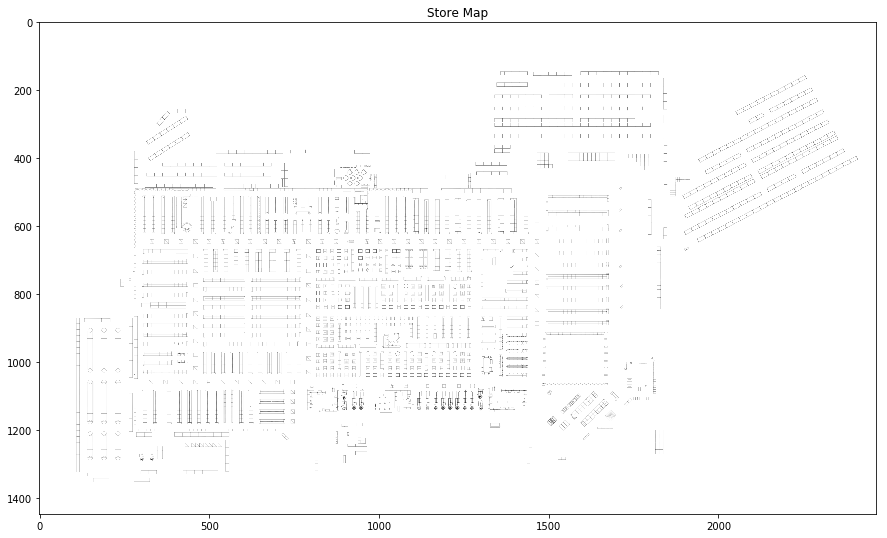

In [63]:
im_gray = cv2.imread('1150.png', cv2.IMREAD_GRAYSCALE)
display_img(im_gray)

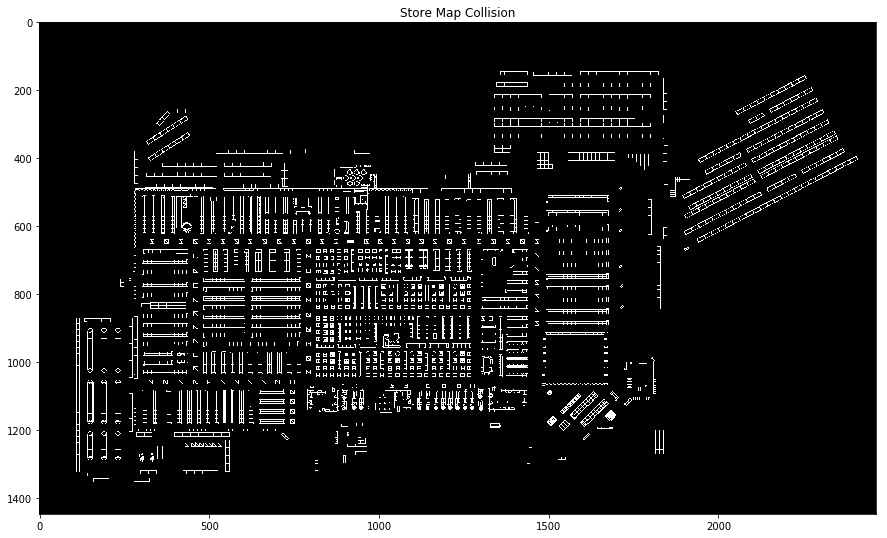

In [64]:
thresh, im_bw = cv2.threshold(im_gray, 254, 255, cv2.THRESH_BINARY_INV)
display_img(im_bw, title="Store Map Collision")

## Generating the Collision Map

Next, we'll use the contours to determine what regions are considered inaccessible.

In [65]:
im_bw.shape

(1448, 2466)

In [66]:
cv2.findContours?

In [67]:
print(cv2.__version__)

4.1.1


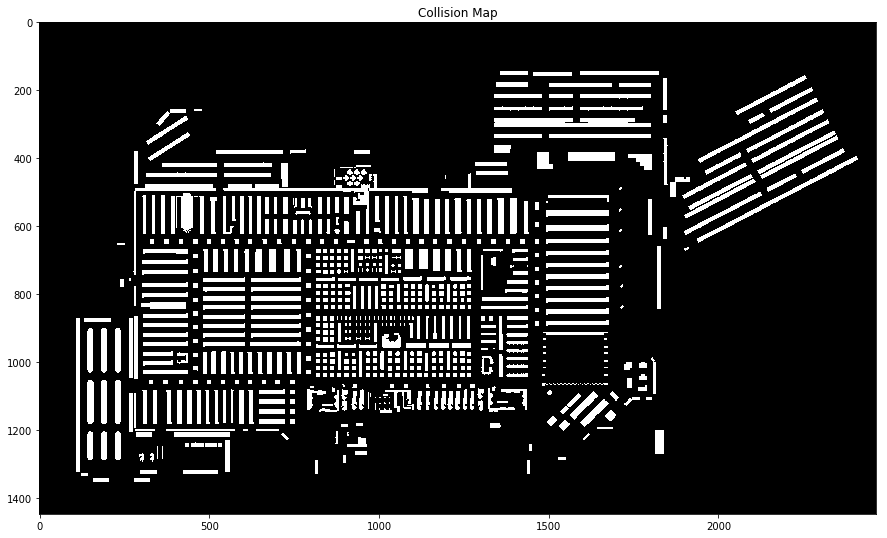

In [68]:
collision_map = im_bw.copy()
contour, hier = cv2.findContours(collision_map, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
for cnt in contour:
    cv2.drawContours(collision_map, [cnt], 0, 255, -1)
display_img(collision_map, title="Collision Map")

## Determining Target Points

Next, we'll find the target points by looking at the edges of our collision map and selecting non-zero points on those edges. These locations will eventually be manually overwrriten with 0s to make them accessible.

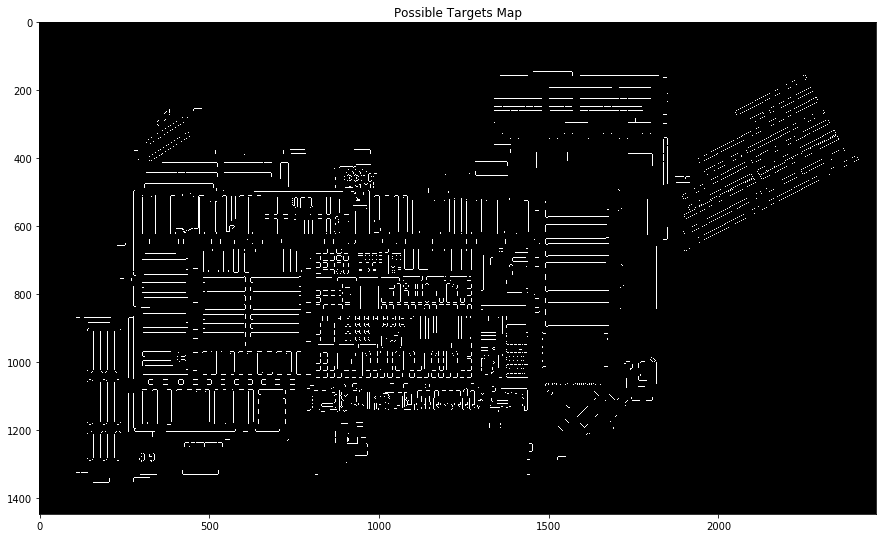

In [69]:
valid_targets = cv2.Laplacian(collision_map, cv2.CV_64F)
display_img(valid_targets, title="Possible Targets Map")

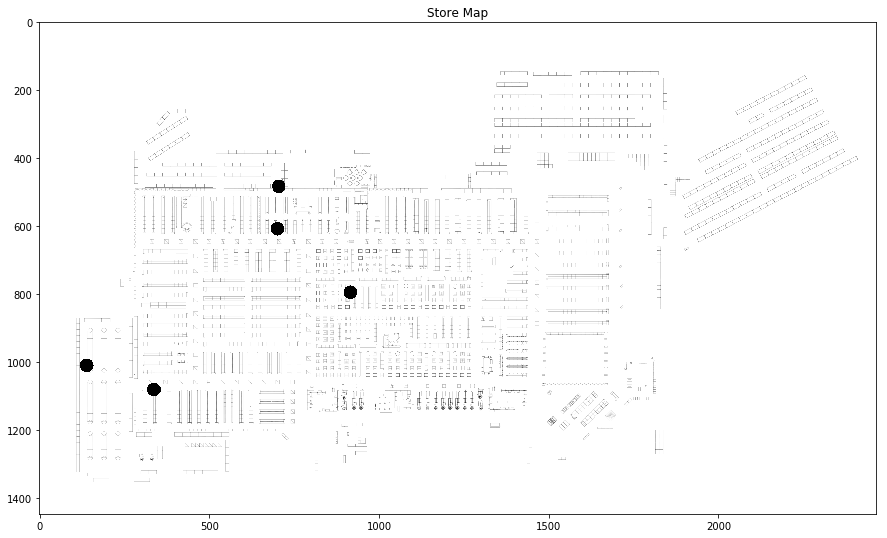

In [70]:
random.seed(target_seed)
im_targets = im_gray.copy()
ys, xs = valid_targets.nonzero()
target_indicies = random.sample(range(len(xs)), N_targets)
target_xs, target_ys = xs[target_indicies], ys[target_indicies]
for x, y in zip(target_xs, target_ys):
    cv2.circle(im_targets, (x, y), circle_draw_size, (0, 255, 0), -1)
display_img(im_targets)

## Generate the Traffic Map

Finally, we'll generate some noise to represent the traffic in the store. This noise represents the per-pixel difficulty of traveling in a particular region of the store. An ideal path is one which traverses all targets while minimizing sum of the path weights along the route. Note that impassable areas have a path weight of inifinity, so going through those points results in the worst possible score.

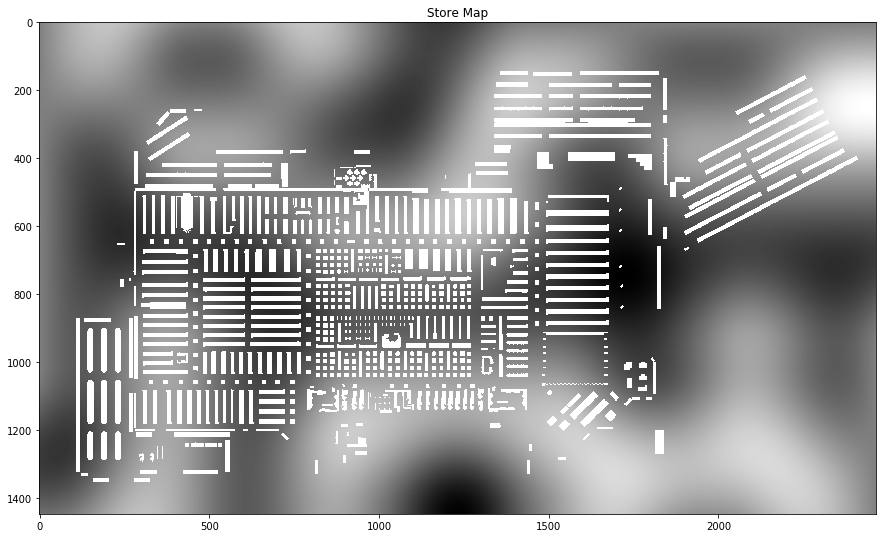

In [71]:
width, height = len(im_targets[0]), len(im_targets)
noise_img = generate_noise_image(width, height, seed=noise_seed)
noise_img = (noise_img - np.min(noise_img)) / (np.max(noise_img) - np.min(noise_img))

travel_friction = (~collision_map>0).astype(int) * noise_img
travel_friction[collision_map>0] = np.inf
for x, y in zip(target_xs, target_ys):
    travel_friction[y][x] = 0

display_img(travel_friction*255)

## Viewing the Final Objective

Now that we have the travel friction map (i.e. the map of the difficulty of traversing every point on the image) and a list of the goal points, a path can be generated which minimizes the sum of the weights while visiting points adjacent to every goal point. Note that diagonal motion is not allowed - only horizontal or vertical moves are permitted. Also note that all goal points are considered "0" weight, meaning there is no cost for visiting the goal point.

The circles in this image to not indicate weights - they are markers. The travel_friction image is the one upon which you will be judged. Remember this image will have random noise and points, so do not assume it will be identical each time.

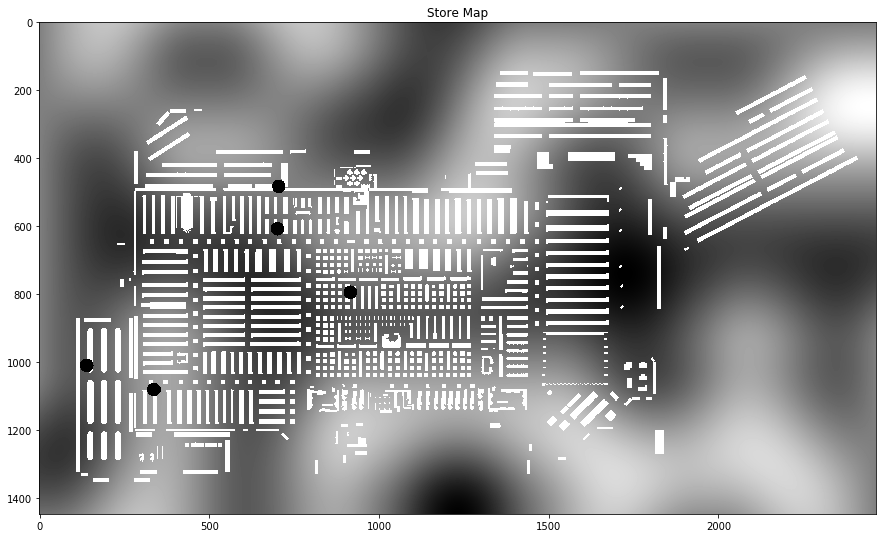

In [72]:
from PIL import Image
goal_image = travel_friction.copy()
for x, y in zip(target_xs, target_ys):
    cv2.circle(goal_image, (x, y), circle_draw_size, (0, 0, 0), -1)
display_img(goal_image*255)

# Problem Function

This function will return, given two random seeds, a traffic map and a set of target locations. You can use any seeds you like during development, but a fixed list of seeds will be used to test every participant. Note that a variable number of targets will be used as well in testing.

In [73]:
def get_traffic_map_and_targets(N_targets, traffic_seed, target_seed, origin=0, scale_factor=5):
    # Load store map
    im_gray = cv2.imread('1150.png', cv2.IMREAD_GRAYSCALE)
    # Binarize
    thresh, im_bw = cv2.threshold(im_gray, 254, 255, cv2.THRESH_BINARY_INV)
    # Fill holes to make impassable areas
    collision_map = im_bw.copy()
    contour, hier = cv2.findContours(collision_map, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    for cnt in contour:
        cv2.drawContours(collision_map, [cnt], 0, 255, -1)
    # Edge detect to generate valid targets
    valid_targets = cv2.Laplacian(collision_map, cv2.CV_64F)
    # Generate random targets
    random.seed(target_seed)
    im_targets = im_gray.copy()
    ys, xs = valid_targets.nonzero()
    target_indicies = random.sample(range(len(xs)), N_targets)
    target_xs, target_ys = xs[target_indicies], ys[target_indicies]
    # Generate noise image for traffic
    width, height = len(im_targets[0]), len(im_targets)
    noise_img = generate_noise_image(width, height, seed=noise_seed, origin=origin, scale_factor=scale_factor)
    noise_img = (noise_img - np.min(noise_img)) / (np.max(noise_img) - np.min(noise_img))
    # Merge noise and collisions
    travel_friction = (~collision_map>0).astype(int) * noise_img
    # Enforce collision map infinite condition
    travel_friction[collision_map>0] = np.inf
    # Make targets passable
    for x, y in zip(target_xs, target_ys):
        travel_friction[y][x] = 0
    # Return the friction map and the target points
    return travel_friction, list(zip(target_xs, target_ys))

In [74]:
class Point(complex):
    x = property(lambda p: p.real)
    y = property(lambda p: p.imag)
    
City = Point

def distance(A, B): 
    "The distance between two points."
    return abs(A - B)

In [75]:
def tour_length(tour):
    "The total of distances between each pair of consecutive cities in the tour."
    return sum(distance(tour[i], tour[i-1]) 
               for i in range(len(tour)))

In [76]:
def Cities(targets):
    
    return frozenset(City(x[0],x[1])
                     for x in targets)

In [77]:
def greedy_tsp(cities):
    """Go through edges, shortest first. Use edge to join segments if possible."""
    endpoints = {c: [c] for c in cities} # A dict of {endpoint: segment}
    for (A, B) in shortest_edges_first(cities):
        if A in endpoints and B in endpoints and endpoints[A] != endpoints[B]:
            new_segment = join_endpoints(endpoints, A, B)
            if len(new_segment) == len(cities):
                print()
                return new_segment

In [78]:
def shortest_edges_first(cities):
    "Return all edges between distinct cities, sorted shortest first."
    edges = [(A, B) for A in cities for B in cities 
                    if id(A) < id(B)]
    return sorted(edges, key=lambda edge: distance(*edge))

In [79]:
def join_endpoints(endpoints, A, B):
    "Join B's segment onto the end of A's and return the segment. Maintain endpoints dict."
    Asegment, Bsegment = endpoints[A], endpoints[B]
    if Asegment[-1] is not A: Asegment.reverse()
    if Bsegment[0] is not B: Bsegment.reverse()
    Asegment.extend(Bsegment)
    del endpoints[A], endpoints[B] # A and B are no longer endpoints
    endpoints[Asegment[0]] = endpoints[Asegment[-1]] = Asegment
    return Asegment

In [80]:
def plot_tour(tour): 
    plot_lines(list(tour) + [tour[0]])
    
def plot_lines(points, style='bo-'):
    "Plot lines to connect a series of points."
    plt.plot([p.x for p in points], [p.y for p in points], style)
    plt.axis('scaled'); plt.axis('off')

In [81]:
def plot_tsp(algorithm, cities):
    # Find the solution and time how long it takes
    t0 = time.clock()
    tour = algorithm(cities)
    t1 = time.clock()
    assert valid_tour(tour, cities)
    plot_tour(tour); plt.show()
    print("{} city tour with length {:.1f} in {:.3f} secs for {}"
          .format(len(tour), tour_length(tour), t1 - t0, algorithm.__name__))
    
def valid_tour(tour, cities):
    return set(tour) == set(cities) and len(tour) == len(cities)

In [82]:
def visualize_greedy_tsp(cities, plot_sizes):

    edges = shortest_edges_first(cities) # A list of (A, B) pairs
    endpoints = {c: [c] for c in cities} # A dict of {endpoint: segment}
    for (A, B) in edges:
        if A in endpoints and B in endpoints and endpoints[A] != endpoints[B]:
            new_segment = join_endpoints(endpoints, A, B)
            plot_segments(endpoints, plot_sizes, distance(A, B)) # <<<< NEW
            if len(new_segment) == len(cities):
                return new_segment
        
def plot_segments(endpoints, plot_sizes, dist):
    "If the number of distinct segments is one of plot_sizes, then plot segments."
    segments = set(map(tuple, endpoints.values()))
    if len(segments) in plot_sizes:
        for s in segments:
            plot_lines(s)
        plt.show()
        print('{} segments, longest edge = {:.0f}'.format(
              len(segments), dist))

In [83]:
import heapq
# N_targets = 2
def findmap(TF,S,T):
    sl = 1
    step = [(sl,0),(-sl,0),(0,sl),(0,-sl)]
   
    ndict = {}
    
    n = TF.shape[0]
    m = TF.shape[1]
    result=[]
    x = S[0]
    y = S[1]
 
    Arr_point = 0
    shifts=[150,300,500,800,1000,2000]
    for shi in shifts:
        q = []
        dis = [[float("inf")]*m for i in range(n)]
        Taken = set()
        heapq.heappush(q,[0,[[x,y]]])
        minx=max(0,min(T[0]-shi,S[0]-shi))
        miny=max(0,min(T[1]-shi,S[1]-shi))
        maxx=min(m,max(T[0]+shi,S[0]+shi))
        maxy=min(n,max(T[1]+shi,S[1]+shi))
        dis = np.zeros((n,m), dtype=np.float) + np.inf

        while q:
            #print(q)
            item = heapq.heappop(q)

            if not (item[1][-1][0],item[1][-1][1]) in Taken:

                Taken.add((item[1][-1][0],item[1][-1][1]))


                if item[1][-1]==T:
                    result=item
                    return result

                for j in step:
                    newx = item[1][-1][0] + j[0]
                    newy = item[1][-1][1] + j[1]

                    if minx <= newx and newx < maxx and miny <= newy and newy < maxy and TF[newy][newx] != float("inf"):

                        if not (newx,newy) in Taken:
                            newlen = item[0] + TF[newy][newx]
                            if dis[newy][newx] > newlen:

                                dis[newy][newx] = newlen

                                ite=item[1][:]
                                ite.append([newx,newy])

                                heapq.heappush(q,[newlen,ite])
  
    return result


In [84]:
def findpathpoints(travel_friction, targets):
    targetpoints=Cities(targets)
    tour=greedy_tsp(targetpoints)
    tourcoor=[]
    for t in tour:
        tt=[int(t.real),int(t.imag)]
        tourcoor.append(tt)
    path_points=[]
    for i in range(len(tourcoor)-1):
        res=findmap(travel_friction,tourcoor[i],tourcoor[i+1])
        res=map(tuple,res[1])
  
        path_points.extend(res)
    return path_points
    

In [85]:
travel_friction, targets=get_traffic_map_and_targets(N_targets, noise_seed, target_seed, origin=0, scale_factor=5)
path_points=findpathpoints(travel_friction, targets)

## Scoring and Evaluation

The following function is used for scoring and evaluation. It will throw errors if you do not follow the path rules or if you don't traverse all of the target points. If you pass those two conditions, it will generate a score whose value should be minimized. Note that this score will be infinity if the path traverses an impassable location.

In [86]:
def evaluate_path(traffic_map, target_points, path_points):
    # Confirm the path is contiguous
    for i in range(0, len(path_points) - 1):
        if np.abs(path_points[i][0] - path_points[i+1][0]) + np.abs(path_points[i][1] - path_points[i+1][1]) > 1:
            raise ValueError('Error in path between {0} @ {1} and {2} @ {3}. The path given by path_points has jumps - the path must never move more than 1 square in either the horizontal or vertical direction. Diagonal is not allowed.'.format(i, path_points[i], i+1, path_points[i+1]))
    # Confirm all points were visited
    for idx, tp in enumerate(target_points):
        if tp not in path_points:
            raise ValueError('Not all target points were visited. Point {0} @ {1} was not visited. Stopping evaluation.'.format(idx, tp))
    # Determine the score
    score = 0
    for pp in path_points:
        score += traffic_map[pp[1]][pp[0]]
    return score

In [87]:
evaluate_path(travel_friction, targets, path_points)

718.3172148783744

## Visualization and Examples

Finally, it is recommended you visualize both the target and your paths to understand the choices your system makes.

In [88]:
def draw_path(img, path, color=1.0):
    tmp = img.copy()
    for p in path:
        tmp[p[1]][p[0]] = color
    return tmp


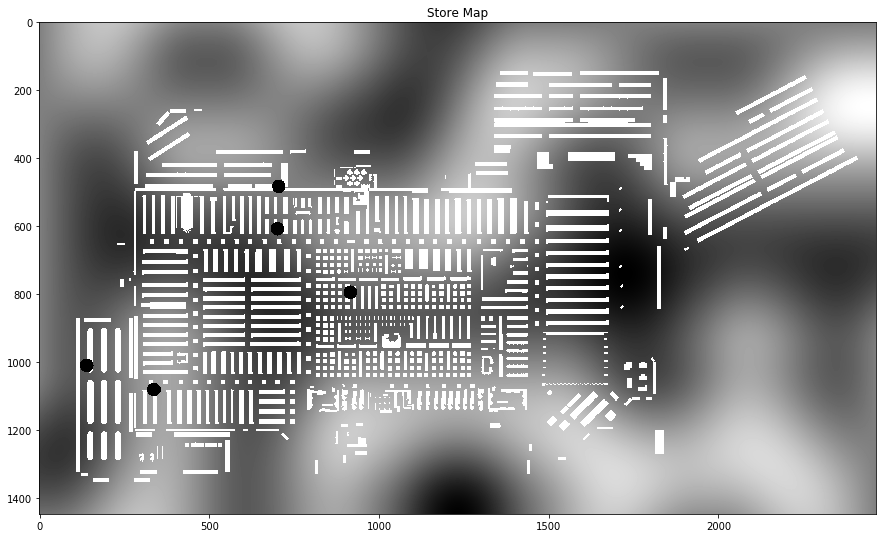

In [90]:
map_img=travel_friction
target_points = targets
disp_img = map_img.copy()
for t in target_points:
    x=t[0]
    y=t[1]
    cv2.circle(disp_img, (x, y), circle_draw_size, (0, 0, 0), -1)
display_img(disp_img*255)

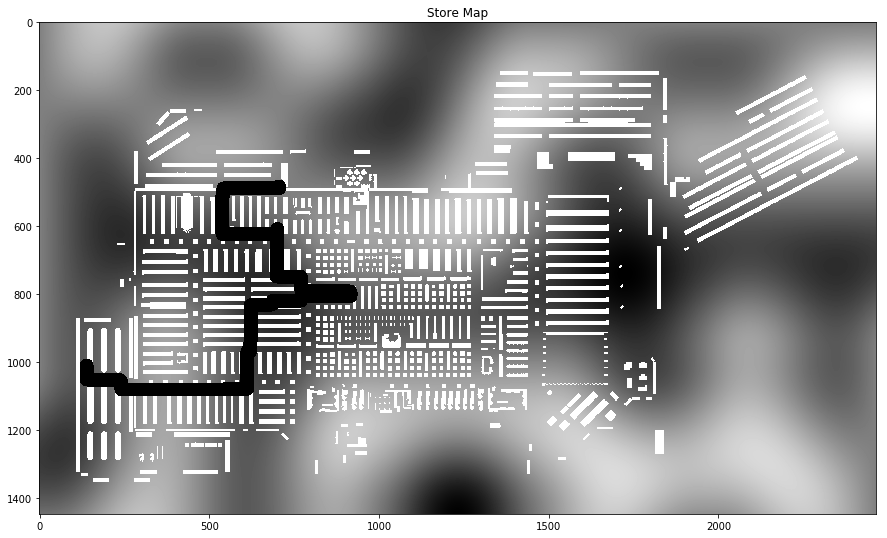

In [89]:
map_img=travel_friction
target_points = path_points
disp_img = map_img.copy()
for t in target_points:
    x=t[0]
    y=t[1]
    cv2.circle(disp_img, (x, y), circle_draw_size, (0, 0, 0), -1)
display_img(disp_img*255)